### Testing

In [1]:
import os
import numpy as np
from PIL import Image, ImageOps
import nibabel as nib
import matplotlib.pyplot as plt
import os
import random
import numpy as np


In [2]:
IMAGE_SIZE = 128
IMAGE_CHANNELS = 3
NII_ROOT = './data/models/CRL_FetalBrainAtlas_2017v3/'
USG_IMAGES = "./data/usg"
MRI_IMAGES="./data/models/images"

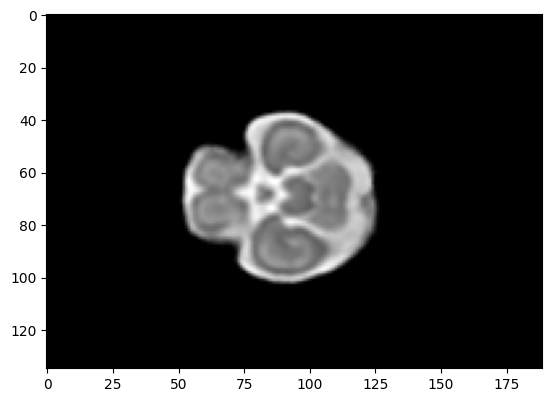

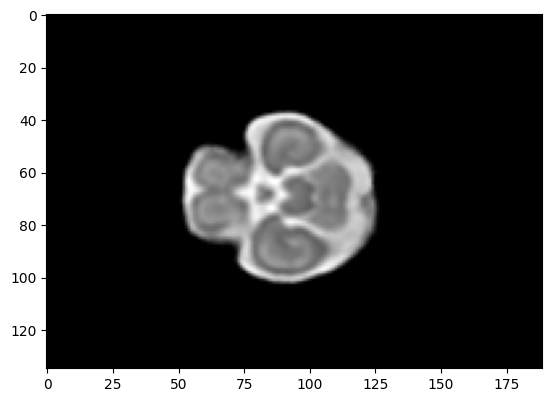

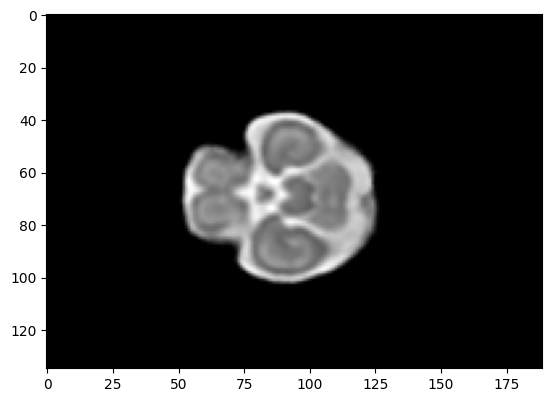

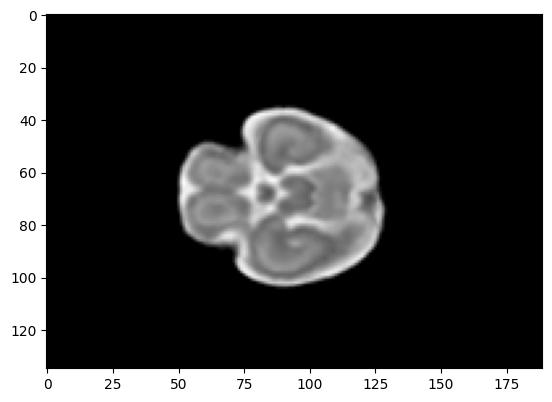

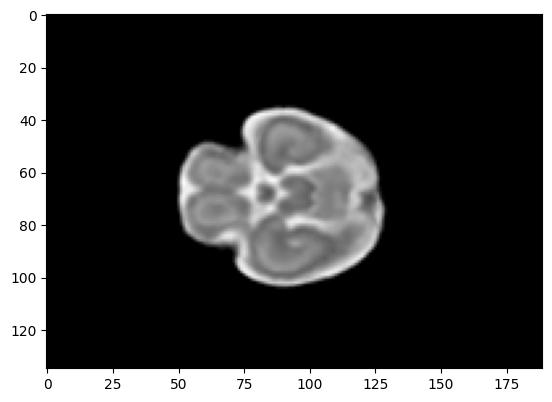

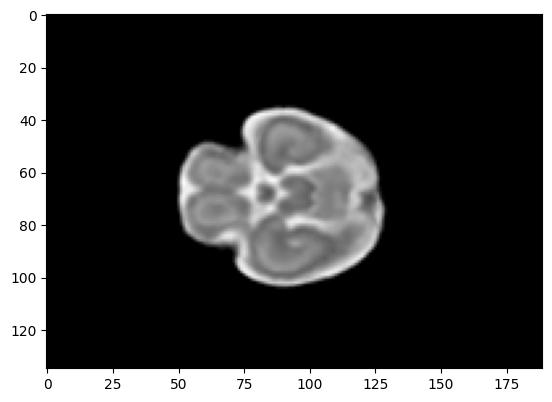

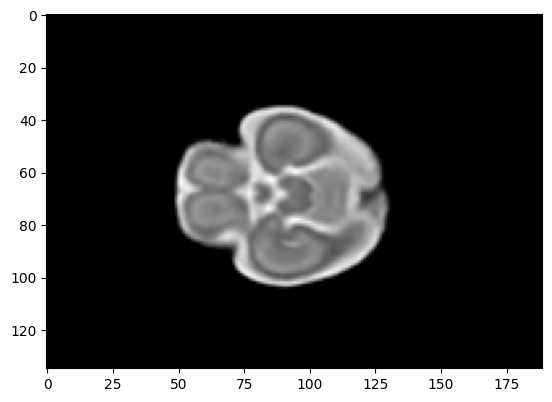

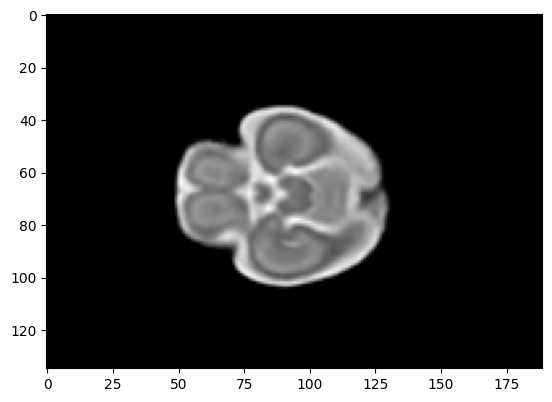

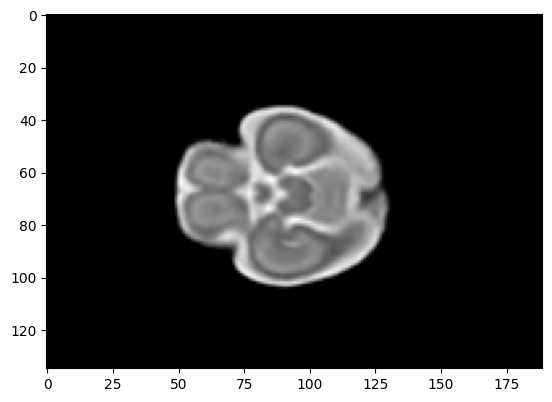

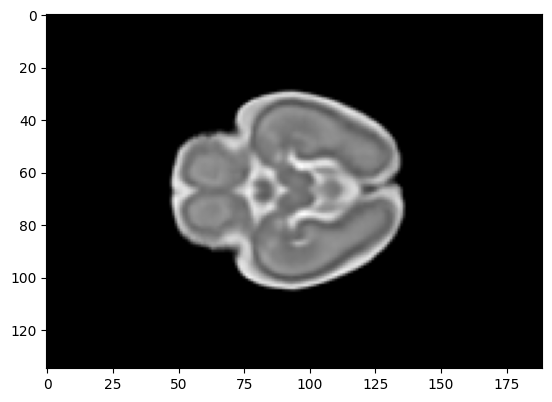

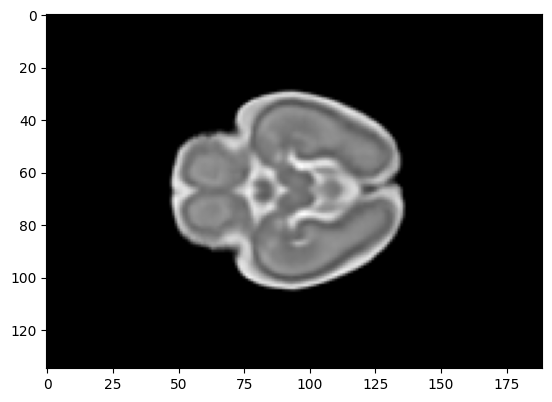

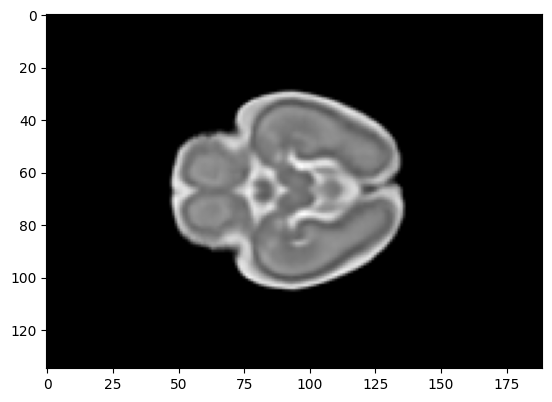

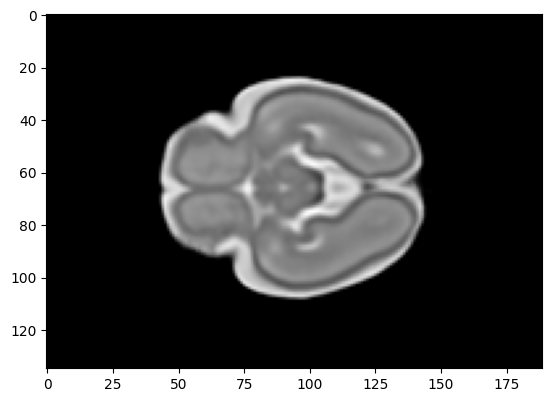

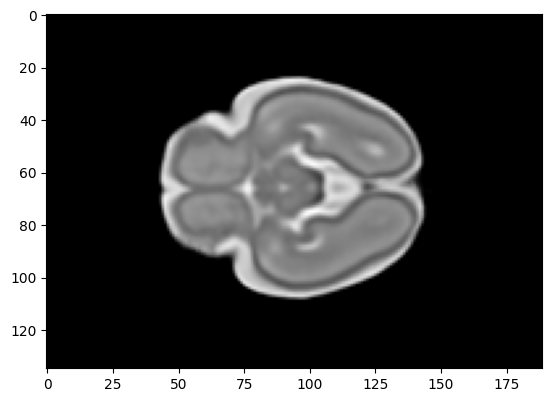

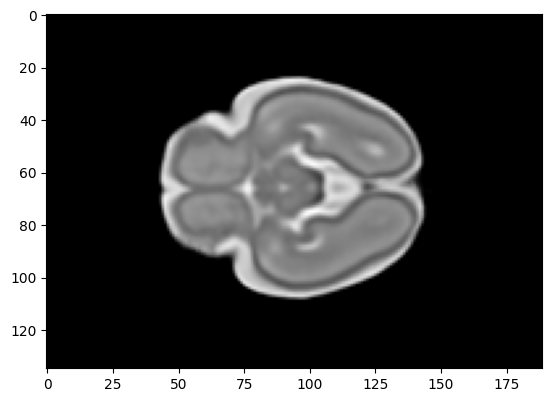

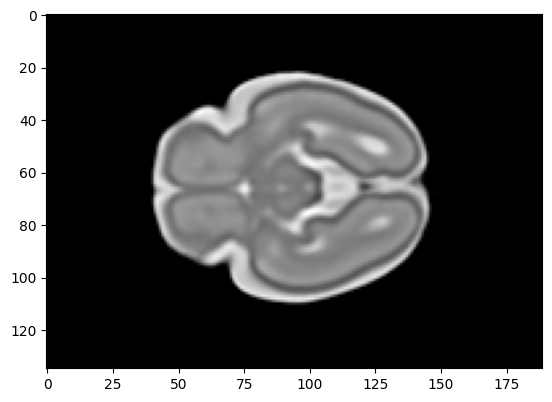

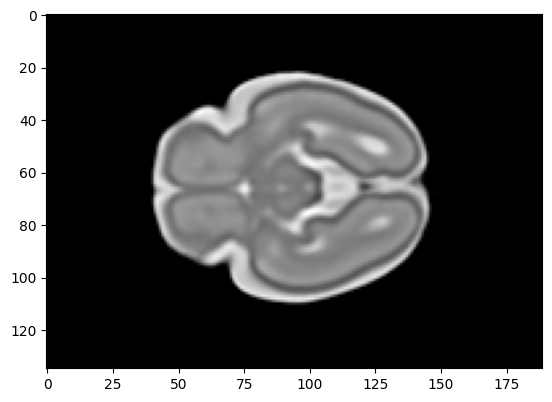

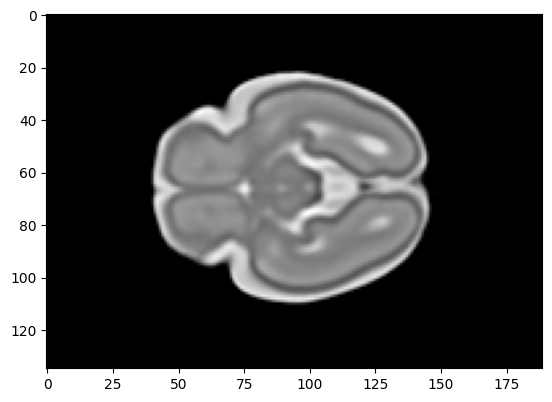

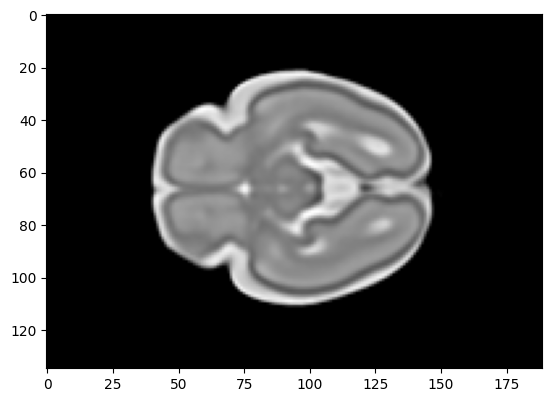

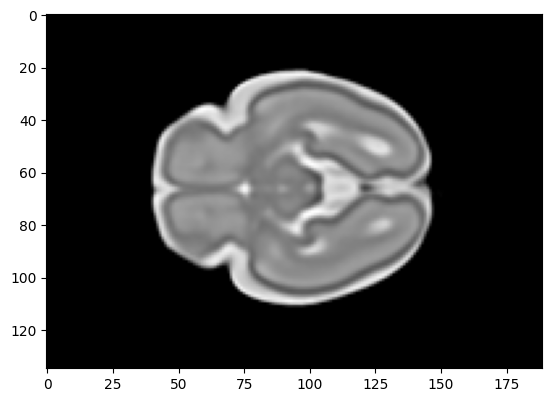

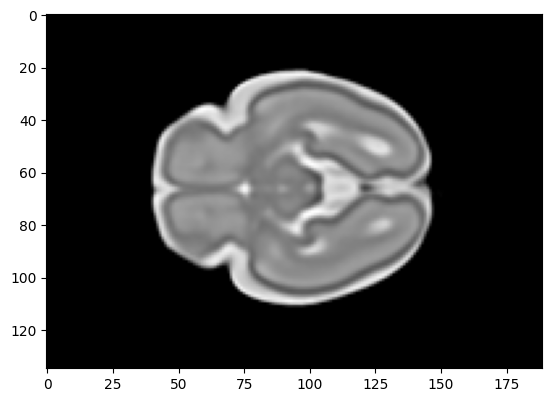

KeyboardInterrupt: 

In [91]:
def save_nii_too_image(root_path: str, images_destination, images_per_file=1) -> None:
    checked_files = []
    for filename in os.listdir(root_path):
        if (not filename.__contains__("nii.gz")) or  filename.__contains__("regional") or filename.__contains__("tissue"):
            continue
        try:
            file_path = os.path.join(root_path, filename)
            nifti_img = nib.load(file_path)
            nii_data = nifti_img.get_fdata()
            slices = []
            for slice_Number in range(75, 105, 5):
                slices.append(nii_data[:, :, slice_Number])
            drafts = np.random.randint(0, len(slices), images_per_file)
            for i, x in enumerate(drafts):
                image = slices[0]
                image_scaled = ((image - np.min(image)) /
                                (np.max(image) - np.min(image))) * 255
                im = Image.fromarray(
                    image_scaled).convert("RGB")
                plt.imshow(im)
                plt.show()
                #im.save(images_destination+f'/{filename}_{i}.jpeg')
        except Exception as ex:
            raise ex

    print(checked_files)


save_nii_too_image(NII_ROOT, "./data/models/images", 3)

# for filename in os.listdir(NII_ROOT):
#   if (not filename.__contains__("nii.gz")) or filename.__contains__("regional") or filename.__contains__("tissue"):
#       continue
#   try:
#     for i in range(75, 105, 5):
#       file_path = os.path.join(NII_ROOT, filename)
#       print(filename, i)
#       nifti_img = nib.load(file_path)
#       nii_data = nifti_img.get_fdata()
#       print(nifti_img.shape)
#       test = nii_data[:, :, i]
#       plt.imshow(test)
#       plt.show()
#   except Exception as ex:
#     print(ex)
#     pass


In [4]:
def prepeare_data(images_path:str, output_numpy_loc: str | None)->np.ndarray:
    data = []
    for filename in os.listdir(images_path):
        path = os.path.join(images_path, filename)
        image = Image.open(path).resize((IMAGE_SIZE, IMAGE_SIZE), Image.LANCZOS)
        # plt.imshow(image)
        # plt.show()
        data.append(np.asarray(image))
        
    data = np.reshape(
        data, (-1, IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS))
    
    #data = data / 127.5 - 1
    
    if output_numpy_loc:
        np.save(output_numpy_loc, data)
    return data

In [5]:
from keras.layers import Input, Reshape, Dropout, Dense, Flatten, BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
import numpy as np
from keras.applications import ResNet50


In [6]:
# Preview image Frame
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 4
SAVE_FREQ = 100  # Size vector to generate images from
NOISE_SIZE = 100
# Configuration
EPOCHS = 50  # number of iterations
BATCH_SIZE = 16
GENERATE_RES = 3
IMAGE_SIZE = 128  # rows/colsIMAGE_CHANNELS = 3


In [7]:

def build_discriminator(image_shape):    
    big_model = ResNet50(include_top=False,
                          weights='imagenet',
                          input_shape=(128,128,3))
    big_model.trainable = False
    X = big_model.output
    X = Flatten()(X)

    X = Dense(512, activation='relu', kernel_initializer='he_uniform')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Dense(256, activation='relu', kernel_initializer='he_uniform')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    output = Dense(1, activation='softmax')(X)
    model = Model(inputs=big_model.input, outputs=output)
    return model


build_discriminator((IMAGE_SIZE,IMAGE_SIZE,3))

In [8]:
from keras.layers import Add
def build_generator(image_size, channels):
    # Input layer
    input = Input(shape=image_size)

    # Downsampling block
    x = Conv2D(32, kernel_size=3, strides=2, padding="same")(input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)

    # Convolutional block
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Activation("relu")(x)
    # Convolutional block
    

    # Residual blocks
    res_blocks = 12
    for i in range(res_blocks):
        res = x
        x = Conv2D(128, kernel_size=3, padding="same")(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Activation("relu")(x)
        x = Conv2D(64, kernel_size=3, padding="same")(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Add()([x, res])
        x = Activation("relu")(x)

    # Upsampling block
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Activation("relu")(x)

    # Additional convolutional block
    x = Conv2D(32, kernel_size=3, padding="same")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Activation("relu")(x)

    # Output layer
    x = Conv2D(channels, kernel_size=3, padding="same")(x)
    output = Activation("tanh")(x)

    # Model
    model = Model(input, output)

    return model

build_generator((IMAGE_SIZE,IMAGE_SIZE,IMAGE_SIZE),3)


In [9]:
image_shape = (IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)
optimizer = Adam(1.5e-4, 0.5)

def build_GAN(generator: Model, discriminator: Model, input:Input) -> Model:
    discriminator.compile(loss="binary_crossentropy",
                        optimizer=optimizer, metrics=["accuracy"])
    generator.compile(loss="binary_crossentropy",
                          optimizer=optimizer, metrics=["accuracy"])
    generator_output = generator(input)
    discriminator.trainable = False
    discriminator_output = discriminator(generator_output)
    gan = Model(input, discriminator_output)
    gan.compile(loss="binary_crossentropy",optimizer=optimizer, metrics=["accuracy"])
    return gan


In [10]:
def plot_images_by_epoch(mri_image, usg_image, epoch:int) -> None:
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    image_clipped = np.clip(usg_image, 0, 1)
    gray_usg = Image.fromarray((image_clipped*255).astype("uint8")).convert('L')
    
    # Plot the second image in the right subplot
    axs[1].imshow(gray_usg, cmap='gray')
    axs[1].set_title(f'Generated USG image ')
    # Plot the first image in the left subplot
    axs[0].imshow(mri_image, cmap='gray')
    axs[0].set_title('MRI Image')
    # Add a title to the whole figure
    fig.suptitle(f'MRI -> USG image transformation, epoch: {epoch}')
    plt.show()


In [11]:
def train(generator:Model, discriminator:Model, epochs: int, mri_images, usg_images ) -> tuple[Model,np.ndarray,np.ndarray]:
    y_real = np.ones((BATCH_SIZE, 1))
    y_fake = np.zeros((BATCH_SIZE, 1))
    gan = build_GAN(
        generator=generator,
        discriminator=discriminator,
        input=Input(shape=(IMAGE_SIZE,IMAGE_SIZE,IMAGE_CHANNELS))
        )
    for epoch in range(epochs):
        idx = np.random.randint(0, mri_images.shape[0], BATCH_SIZE)
        x_real = usg_images[idx]
        generator_input = mri_images[idx]
        x_fake = generator.predict(generator_input)
        if epoch%5 == 0:
            plot_images_by_epoch(mri_images.copy()[idx][0],x_fake.copy()[0],epoch)
        #discriminator.trainable=True
        discriminator_metric_real = discriminator.train_on_batch(x_real, y_real)
        discriminator_metric_generated = discriminator.train_on_batch(x_fake, y_fake)
        #discriminator.trainable = False
        discriminator_metric = 0.5 * np.add(discriminator_metric_real, discriminator_metric_generated)
        generator_metric = gan.train_on_batch(generator_input, y_real)
        print(f"{epoch} epoch, Discriminator loss: {discriminator_metric[0]}, accuracy: {discriminator_metric[1]}, Generator loss: {generator_metric[0]} accuracy: {generator_metric[1]}")
    return gan , discriminator_metric, generator_metric

In [12]:
usg_images = prepeare_data(USG_IMAGES,"usg_images.npy")
mri_images = prepeare_data(MRI_IMAGES,"mri_images.npy")
print("Usg images:", usg_images.shape)
print("Mri images:", mri_images.shape)

Usg images: (199, 128, 128, 3)
Mri images: (54, 128, 128, 3)


1/1 [==============================] - 2s 2s/step


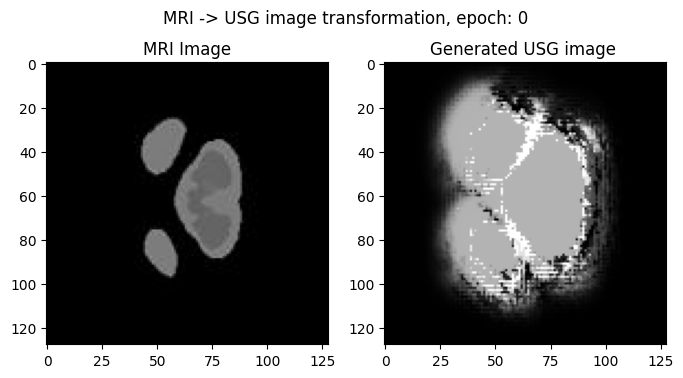

0 epoch, Discriminator loss: 0.8215043544769287, accuracy: 0.5, Generator loss: 0.7477807998657227 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
1 epoch, Discriminator loss: 0.8778850138187408, accuracy: 0.5, Generator loss: 0.6315227746963501 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
2 epoch, Discriminator loss: 0.801611602306366, accuracy: 0.5, Generator loss: 0.5668298602104187 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
3 epoch, Discriminator loss: 0.767934650182724, accuracy: 0.5, Generator loss: 0.5160840749740601 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
4 epoch, Discriminator loss: 0.7902220189571381, accuracy: 0.5, Generator loss: 0.4905781149864197 accuracy: 1.0
1/1 [==============================] - 2s 2s/step


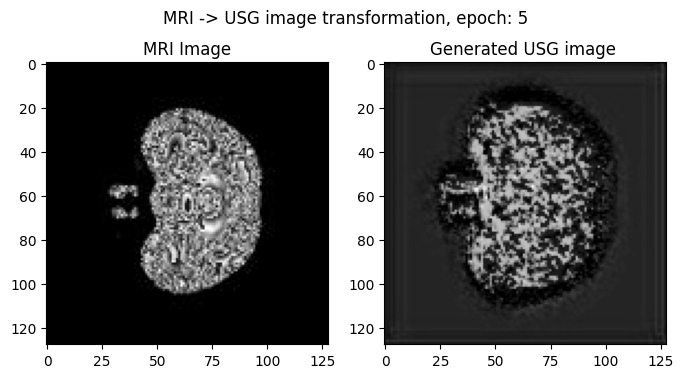

5 epoch, Discriminator loss: 0.8050924241542816, accuracy: 0.5, Generator loss: 0.46441587805747986 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
6 epoch, Discriminator loss: 0.6624027192592621, accuracy: 0.5, Generator loss: 0.4536020755767822 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
7 epoch, Discriminator loss: 0.693968802690506, accuracy: 0.5, Generator loss: 0.4875374436378479 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
8 epoch, Discriminator loss: 0.65336674451828, accuracy: 0.5, Generator loss: 0.47994089126586914 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
9 epoch, Discriminator loss: 0.6235830187797546, accuracy: 0.5, Generator loss: 0.49333417415618896 accuracy: 1.0
1/1 [==============================] - 2s 2s/step


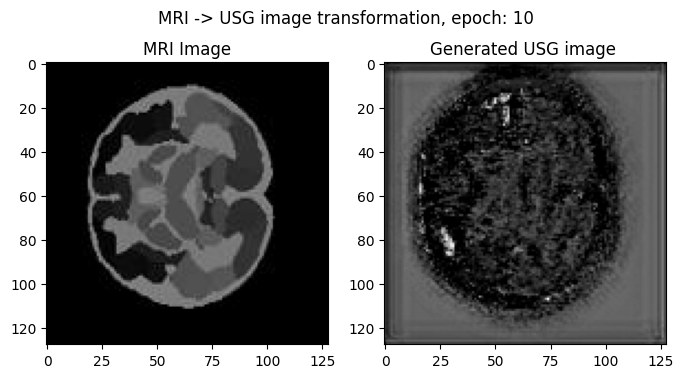

10 epoch, Discriminator loss: 0.6038550138473511, accuracy: 0.5, Generator loss: 0.498342901468277 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
11 epoch, Discriminator loss: 0.579138308763504, accuracy: 0.5, Generator loss: 0.5194682478904724 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
12 epoch, Discriminator loss: 0.56911201775074, accuracy: 0.5, Generator loss: 0.5538763999938965 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
13 epoch, Discriminator loss: 0.5611063838005066, accuracy: 0.5, Generator loss: 0.598608672618866 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
14 epoch, Discriminator loss: 0.5460908263921738, accuracy: 0.5, Generator loss: 0.6026197671890259 accuracy: 1.0
1/1 [==============================] - 2s 2s/step


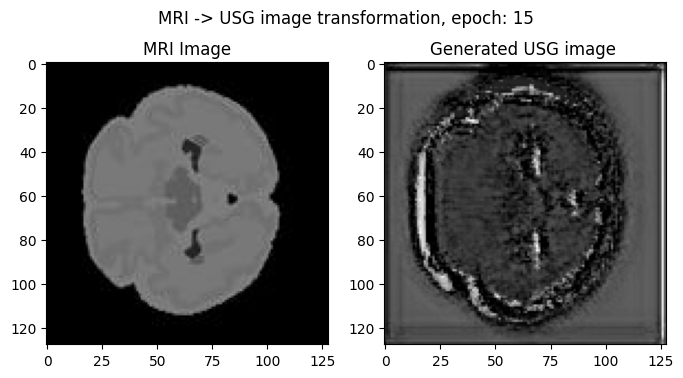

15 epoch, Discriminator loss: 0.4787854850292206, accuracy: 0.5, Generator loss: 0.6506075859069824 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
16 epoch, Discriminator loss: 0.512257844209671, accuracy: 0.5, Generator loss: 0.6943897604942322 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
17 epoch, Discriminator loss: 0.5191964954137802, accuracy: 0.5, Generator loss: 0.6332557797431946 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
18 epoch, Discriminator loss: 0.5514132678508759, accuracy: 0.5, Generator loss: 0.5989120006561279 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
19 epoch, Discriminator loss: 0.4926285445690155, accuracy: 0.5, Generator loss: 0.6159003973007202 accuracy: 1.0
1/1 [==============================] - 2s 2s/step


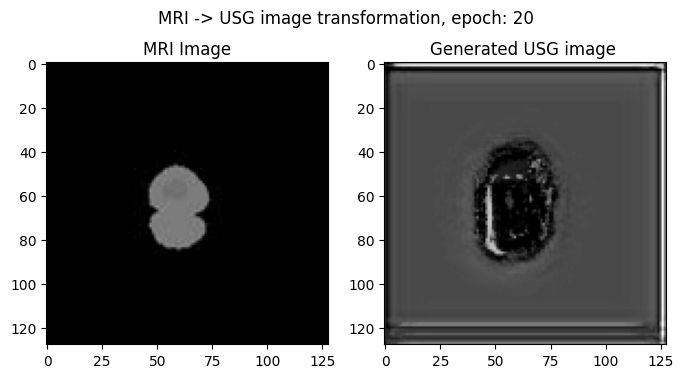

20 epoch, Discriminator loss: 0.49889224767684937, accuracy: 0.5, Generator loss: 0.5964576005935669 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
21 epoch, Discriminator loss: 0.4350344389677048, accuracy: 0.5, Generator loss: 0.6319847106933594 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
22 epoch, Discriminator loss: 0.4212326258420944, accuracy: 0.5, Generator loss: 0.6467079520225525 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
23 epoch, Discriminator loss: 0.4781330078840256, accuracy: 0.5, Generator loss: 0.6075928211212158 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
24 epoch, Discriminator loss: 0.4663700610399246, accuracy: 0.5, Generator loss: 0.5855194330215454 accuracy: 1.0
1/1 [==============================] - 2s 2s/step


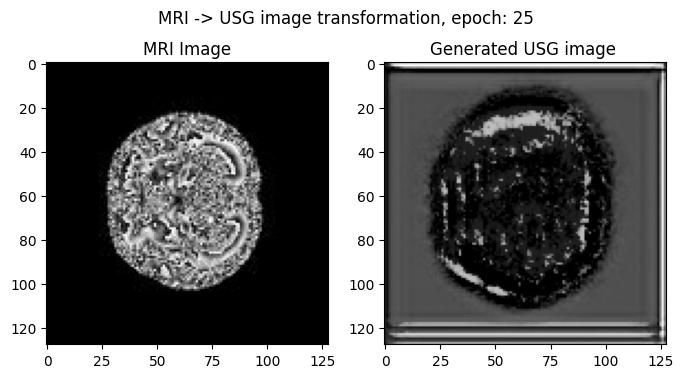

25 epoch, Discriminator loss: 0.43866343796253204, accuracy: 0.5, Generator loss: 0.5887458920478821 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
26 epoch, Discriminator loss: 0.48010075092315674, accuracy: 0.5, Generator loss: 0.5952619314193726 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
27 epoch, Discriminator loss: 0.5407861024141312, accuracy: 0.5, Generator loss: 0.5713780522346497 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
28 epoch, Discriminator loss: 0.40423208475112915, accuracy: 0.5, Generator loss: 0.6376780271530151 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
29 epoch, Discriminator loss: 0.4654848724603653, accuracy: 0.5, Generator loss: 0.6248920559883118 accuracy: 1.0
1/1 [==============================] - 2s 2s/step


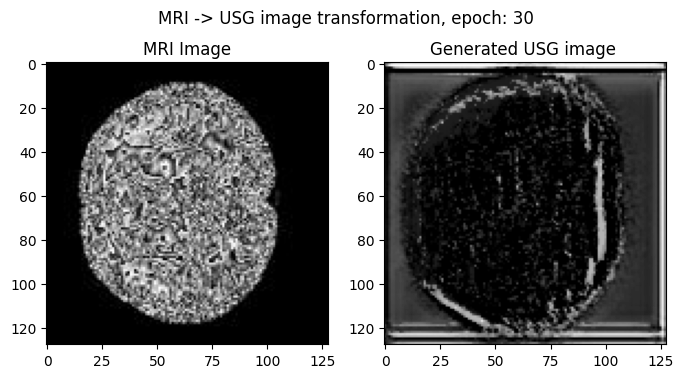

30 epoch, Discriminator loss: 0.43714767694473267, accuracy: 0.5, Generator loss: 0.5688643455505371 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
31 epoch, Discriminator loss: 0.43402935564517975, accuracy: 0.5, Generator loss: 0.5984431505203247 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
32 epoch, Discriminator loss: 0.5010641813278198, accuracy: 0.5, Generator loss: 0.6757534146308899 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
33 epoch, Discriminator loss: 0.42206454277038574, accuracy: 0.5, Generator loss: 0.6959390640258789 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
34 epoch, Discriminator loss: 0.39185041189193726, accuracy: 0.5, Generator loss: 0.816186785697937 accuracy: 1.0
1/1 [==============================] - 2s 2s/step


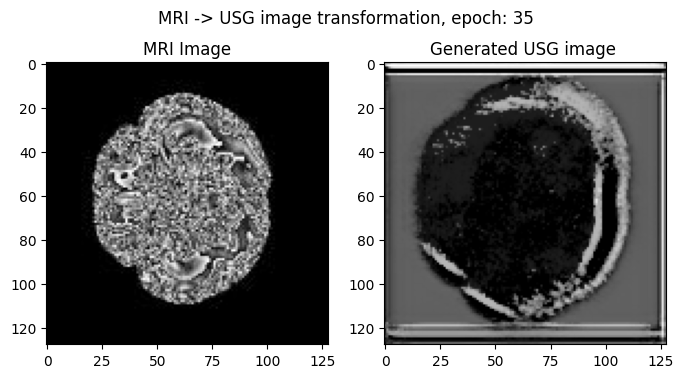

35 epoch, Discriminator loss: 0.39024272561073303, accuracy: 0.5, Generator loss: 0.7880051136016846 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
36 epoch, Discriminator loss: 0.3953799456357956, accuracy: 0.5, Generator loss: 0.8827046751976013 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
37 epoch, Discriminator loss: 0.3960674852132797, accuracy: 0.5, Generator loss: 0.9290814399719238 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
38 epoch, Discriminator loss: 0.35207800567150116, accuracy: 0.5, Generator loss: 0.8722708225250244 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
39 epoch, Discriminator loss: 0.4090230315923691, accuracy: 0.5, Generator loss: 1.0282084941864014 accuracy: 1.0
1/1 [==============================] - 2s 2s/step


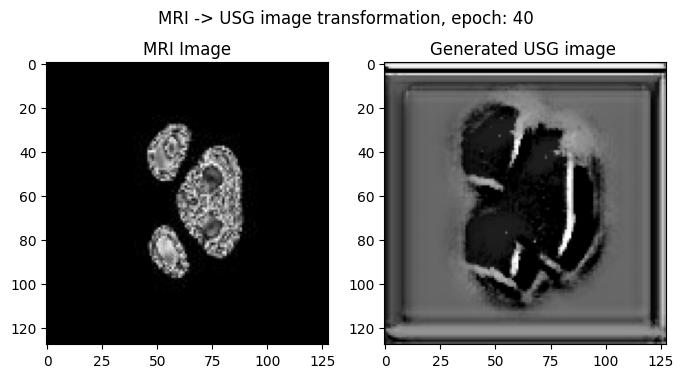

40 epoch, Discriminator loss: 0.3982331454753876, accuracy: 0.5, Generator loss: 0.9555874466896057 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
41 epoch, Discriminator loss: 0.36978879570961, accuracy: 0.5, Generator loss: 0.8489765524864197 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
42 epoch, Discriminator loss: 0.3944815993309021, accuracy: 0.5, Generator loss: 0.9227746725082397 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
43 epoch, Discriminator loss: 0.4803794175386429, accuracy: 0.5, Generator loss: 1.1660257577896118 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
44 epoch, Discriminator loss: 0.4365849196910858, accuracy: 0.5, Generator loss: 1.1453101634979248 accuracy: 1.0
1/1 [==============================] - 2s 2s/step


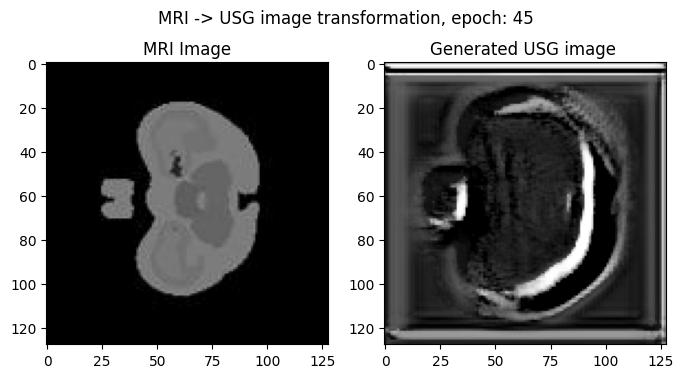

45 epoch, Discriminator loss: 0.37009894847869873, accuracy: 0.5, Generator loss: 1.3363637924194336 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
46 epoch, Discriminator loss: 0.3246408998966217, accuracy: 0.5, Generator loss: 1.6343387365341187 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
47 epoch, Discriminator loss: 0.3388672322034836, accuracy: 0.5, Generator loss: 1.490908145904541 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
48 epoch, Discriminator loss: 0.37030476331710815, accuracy: 0.5, Generator loss: 1.649500846862793 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
49 epoch, Discriminator loss: 0.2968748062849045, accuracy: 0.5, Generator loss: 1.5931565761566162 accuracy: 1.0


In [13]:
image_size = (IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)
gnerator = build_generator(image_size, IMAGE_CHANNELS)
discriminator = build_discriminator(image_size)
model , discriminator_metrics, generator_metrics = train(
    generator=gnerator,
    discriminator=discriminator,
    epochs = 50,
    mri_images=mri_images[:50],
    usg_images=usg_images[:50]
)

In [14]:
def test_discriminator(discriminator:Model, usg_images, mri_images)->None:
    dict = {1: 0, 0: 0}
    for x in usg_images:
        input_data = np.expand_dims(x, axis=0)
        y = discriminator.predict(input_data,verbose=0)
        dict[round(y[0][0])] = dict[round(y[0][0])]+1
        
    for x in mri_images:
        input_data = np.expand_dims(x, axis=0)
        y = discriminator.predict(input_data, verbose=0)
        dict[round(y[0][0])] = dict[round(y[0][0])]+1
    print(dict)
test_discriminator(discriminator,usg_images,mri_images)

{1: 253, 0: 0}


In [15]:
def plot_generator_image(image)->None:
    input_data = np.expand_dims(image, axis=0)
    img = gnerator(input_data).numpy()[0]
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    image_clipped = np.clip(img, 0, 1)
    gray_usg = Image.fromarray((image_clipped*255).astype("uint8")).convert('L')
    # Plot the second image in the right subplot
    axs[1].imshow(gray_usg, cmap='gray')
    axs[1].set_title('Generated USG image')
    # Plot the first image in the left subplot
    axs[0].imshow(np.clip(image, 0, 1) , cmap='gray', vmin=0, vmax=255)
    axs[0].set_title('MRI Image')
    # Add a title to the whole figure
    fig.suptitle('MRI -> USg image transformation')
    plt.show()

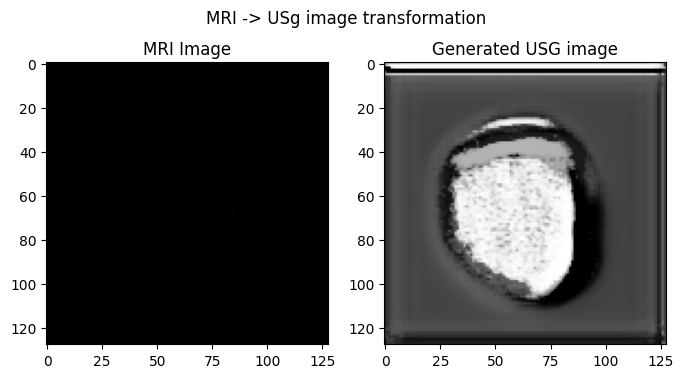

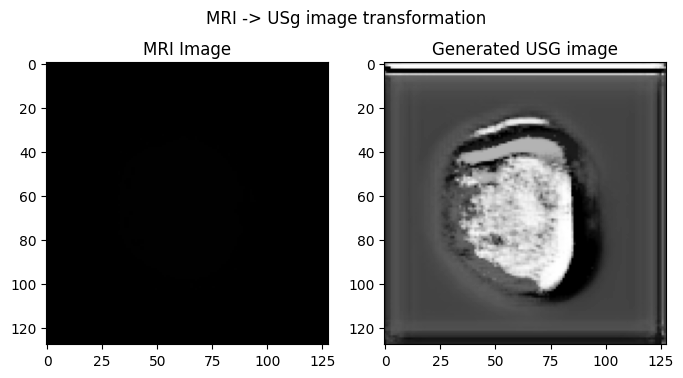

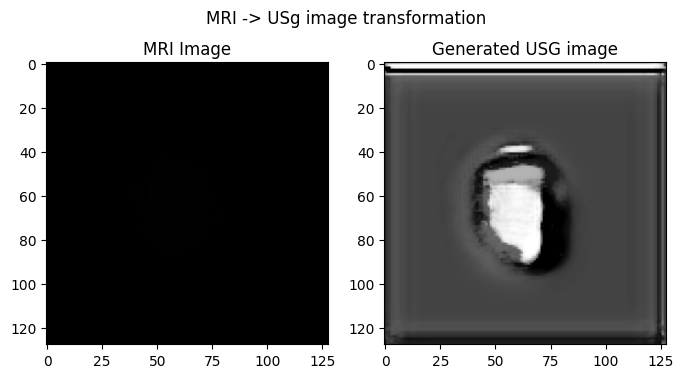

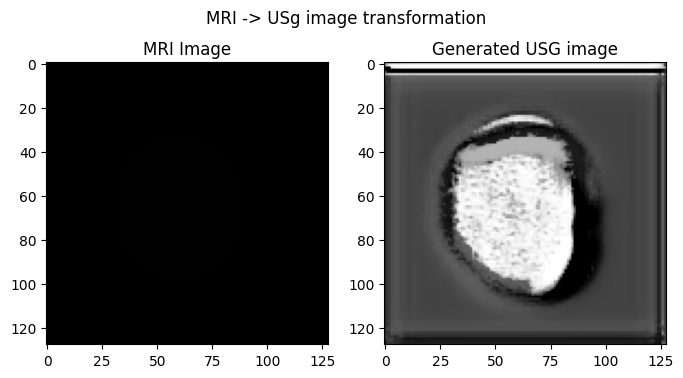

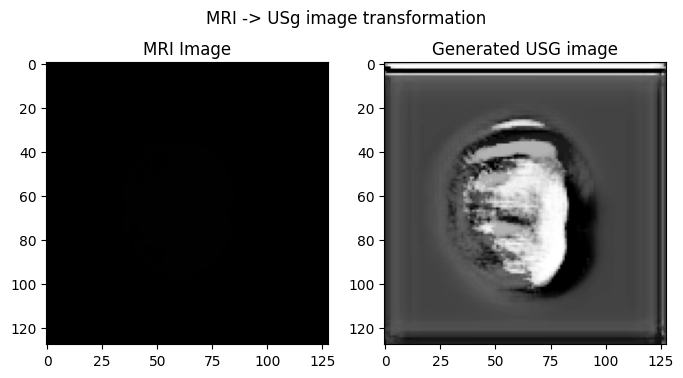

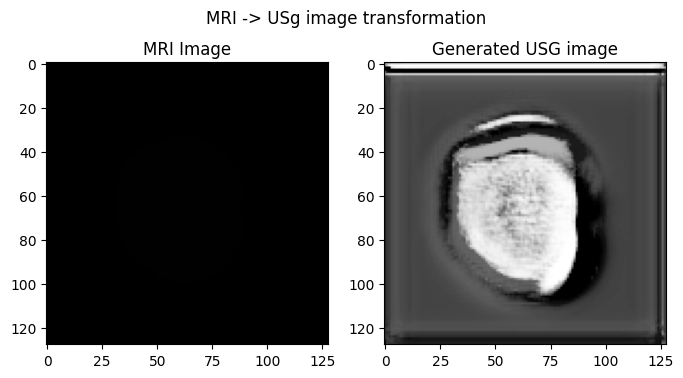

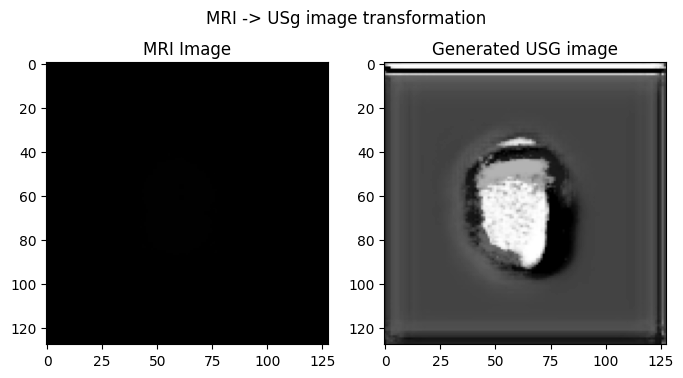

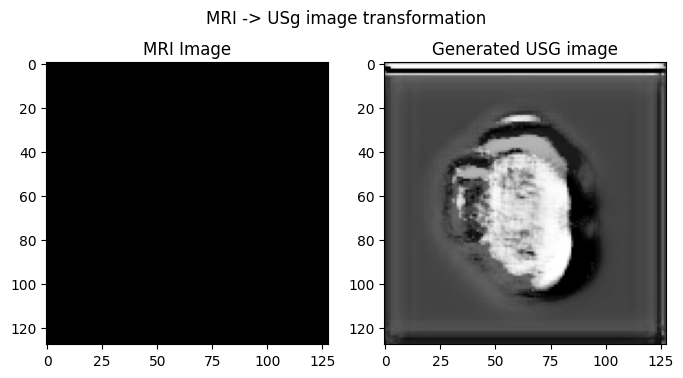

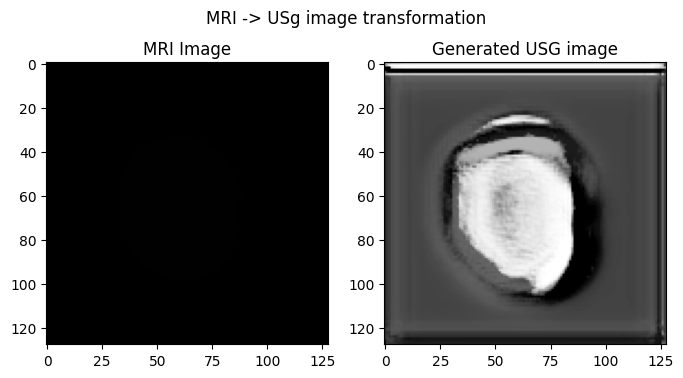

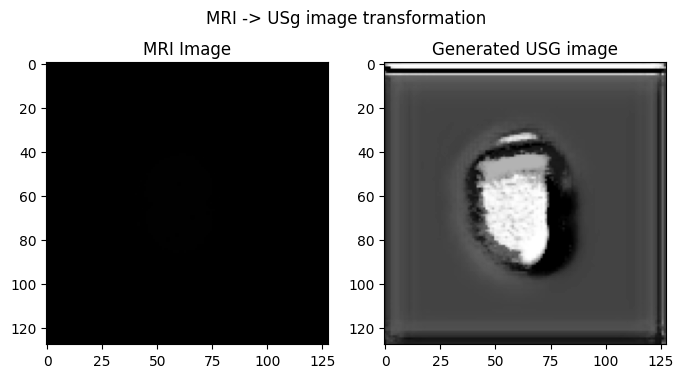

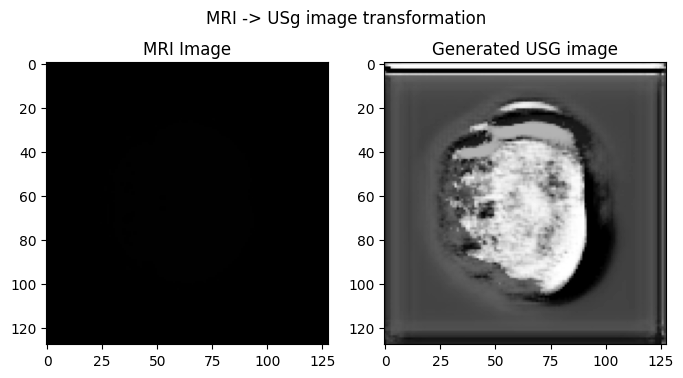

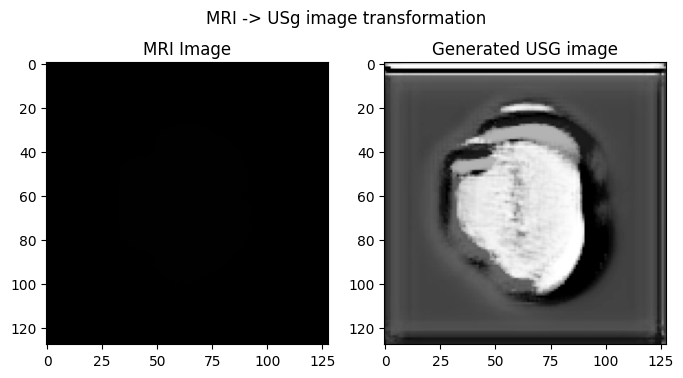

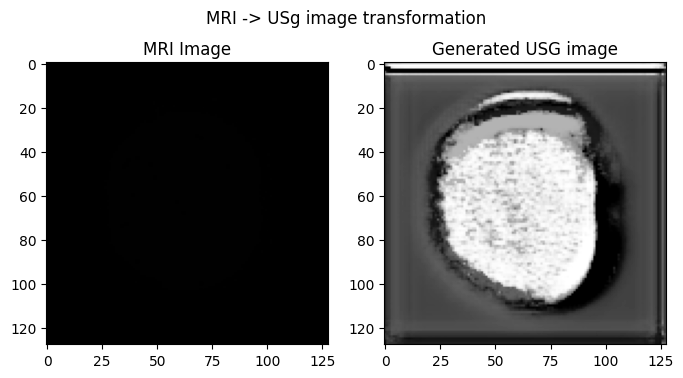

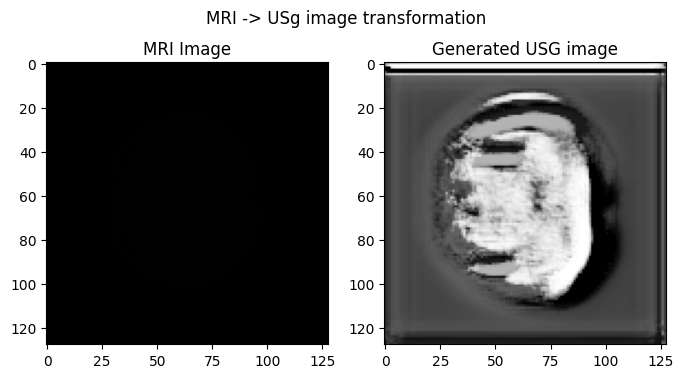

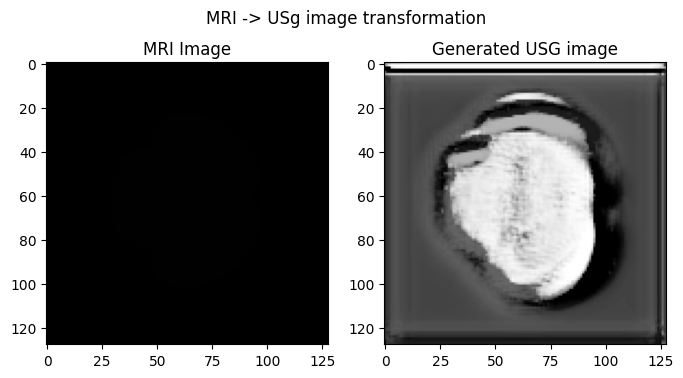

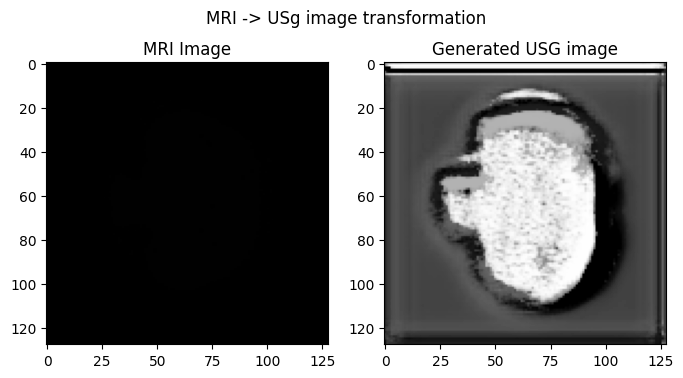

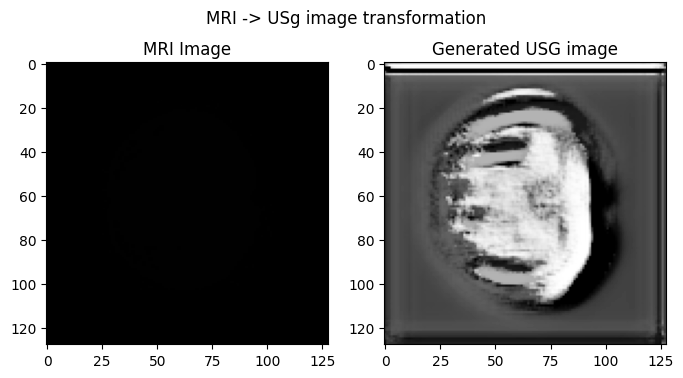

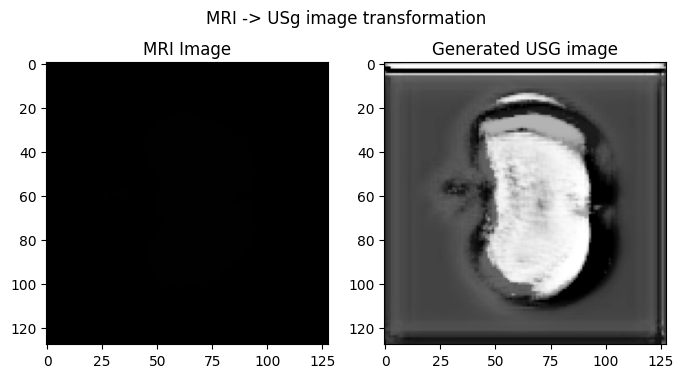

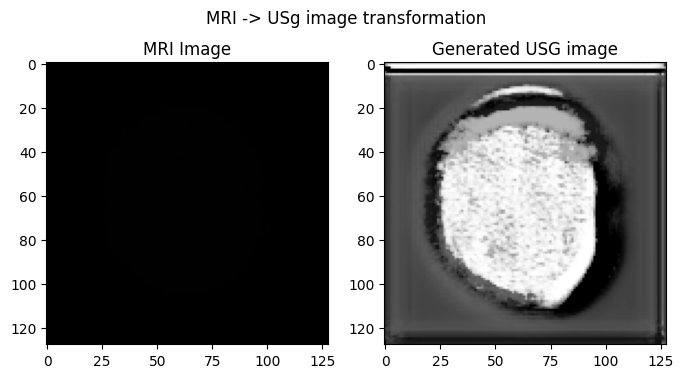

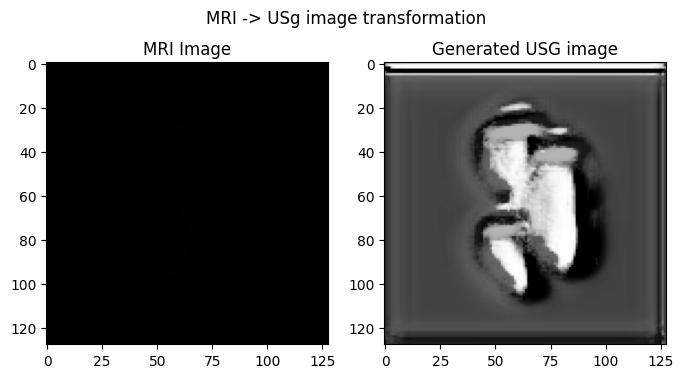

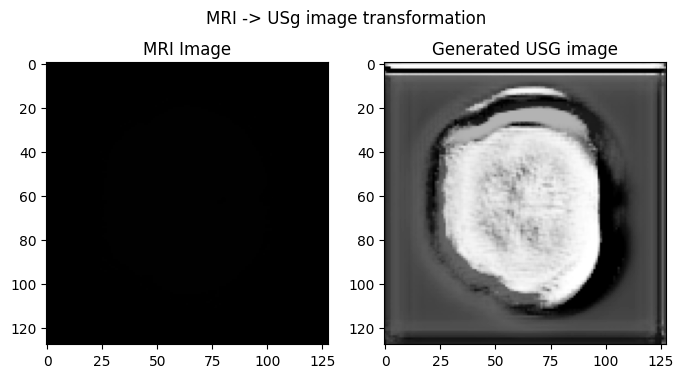

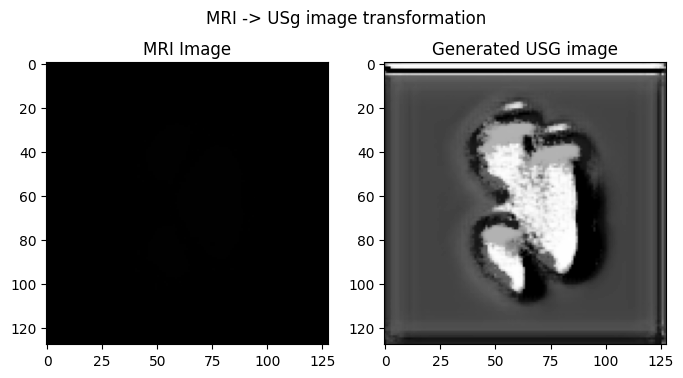

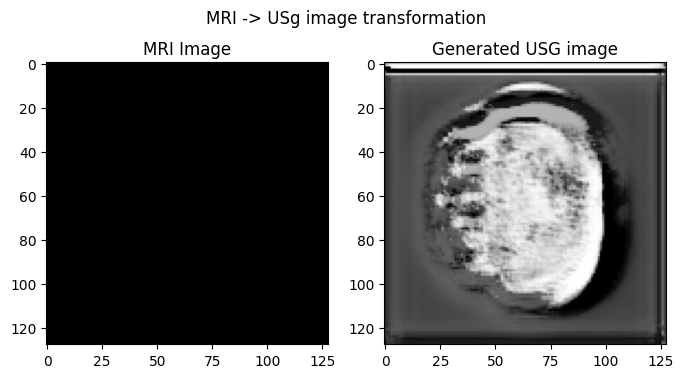

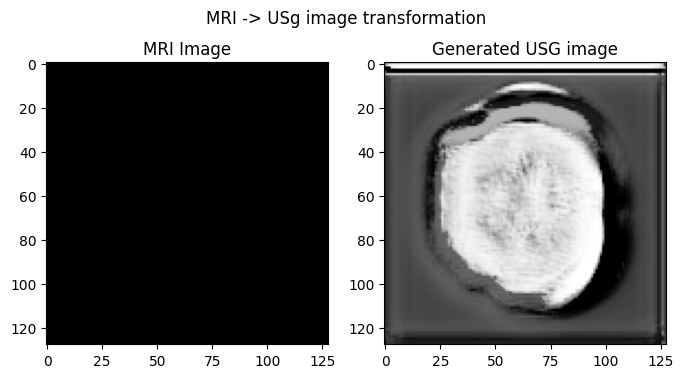

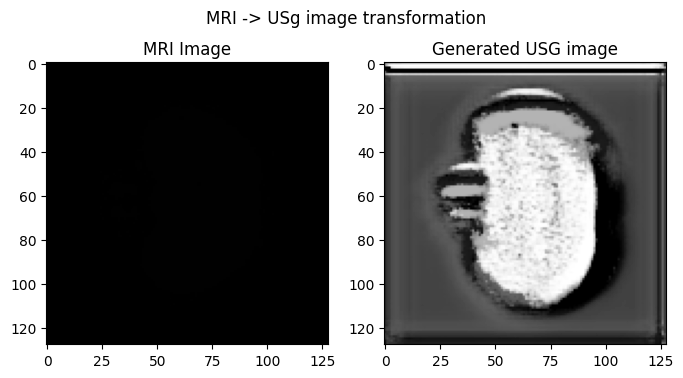

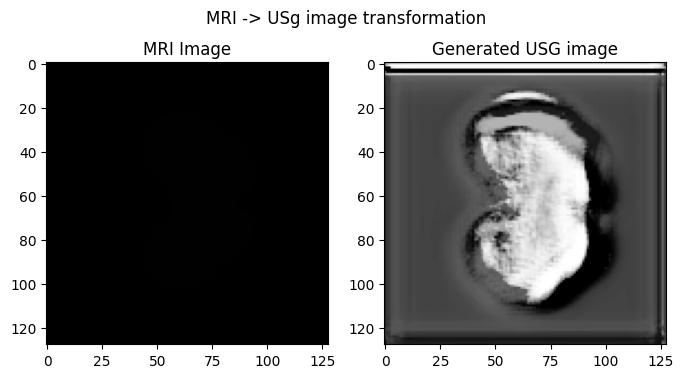

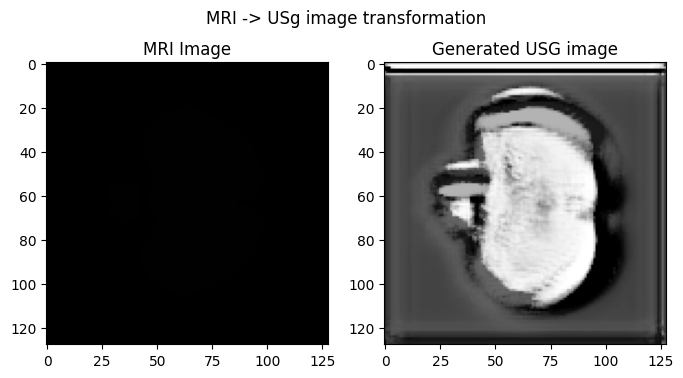

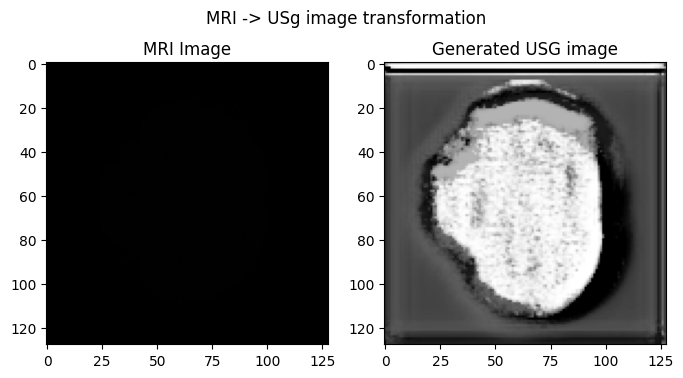

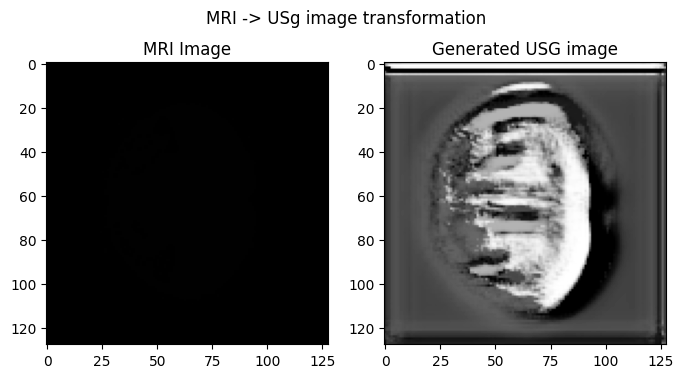

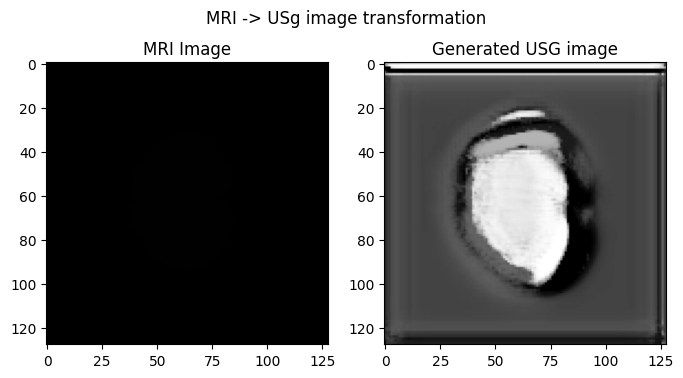

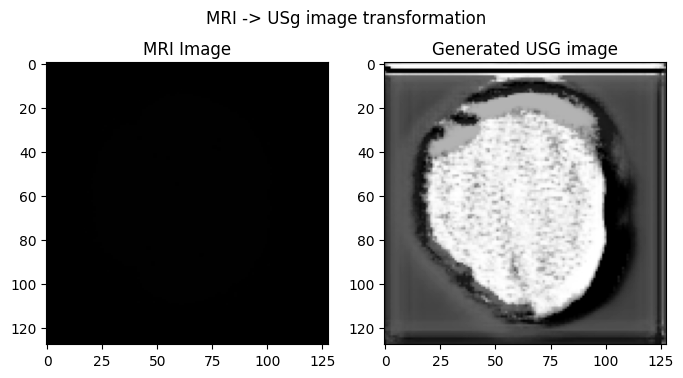

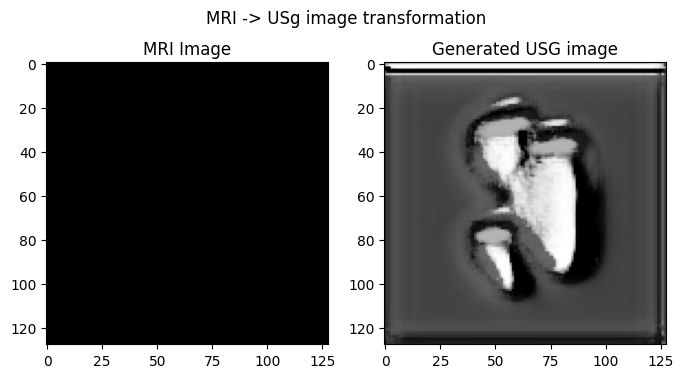

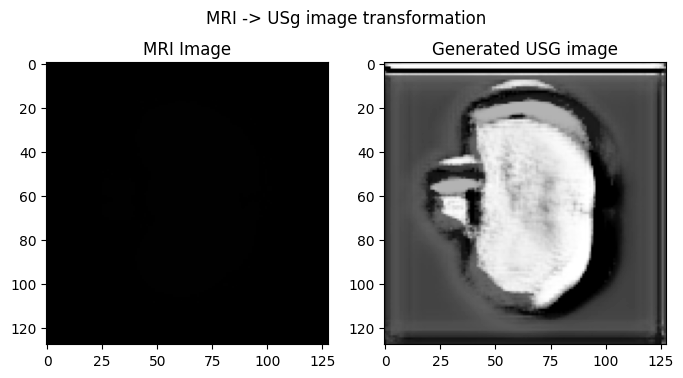

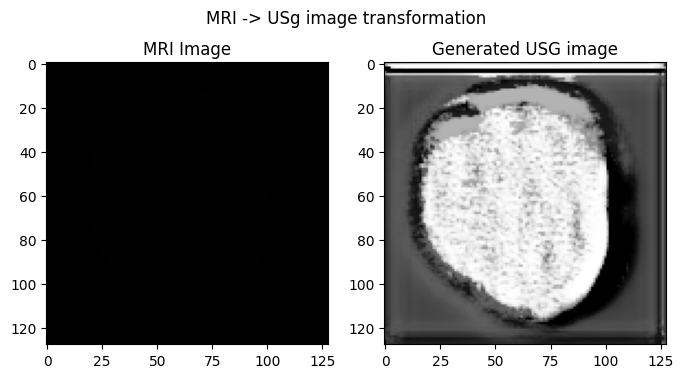

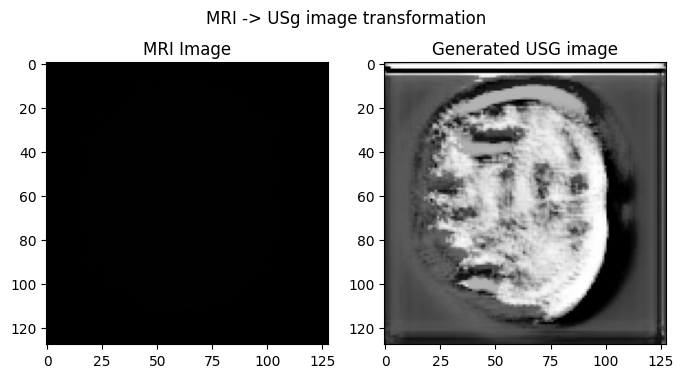

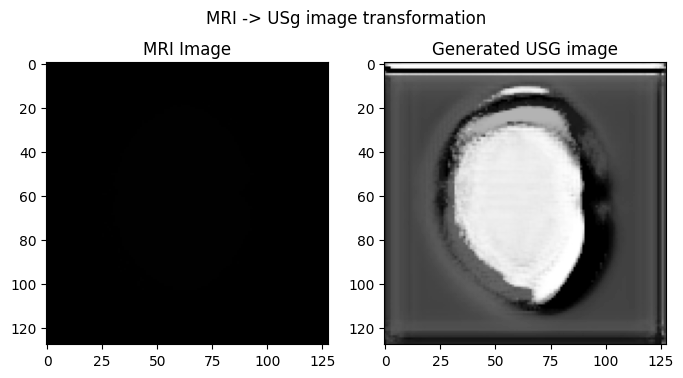

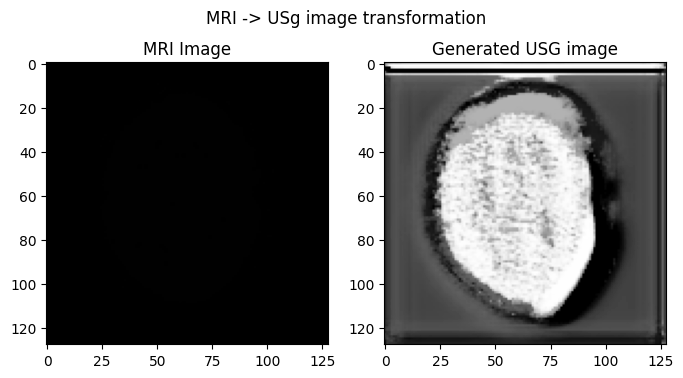

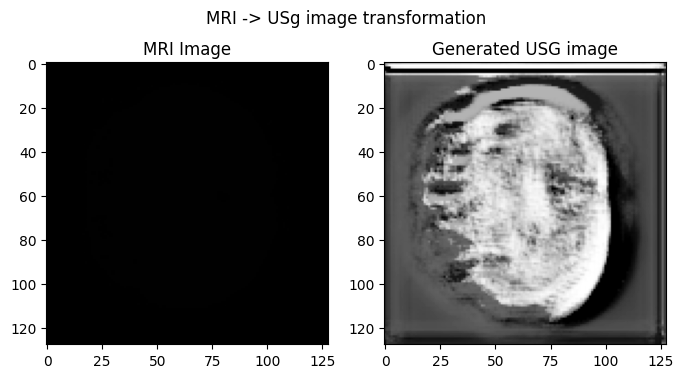

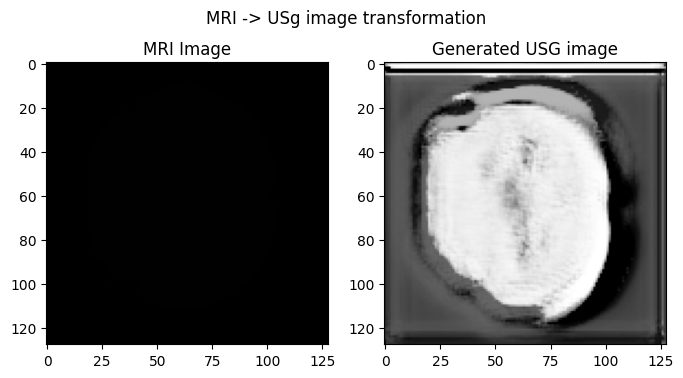

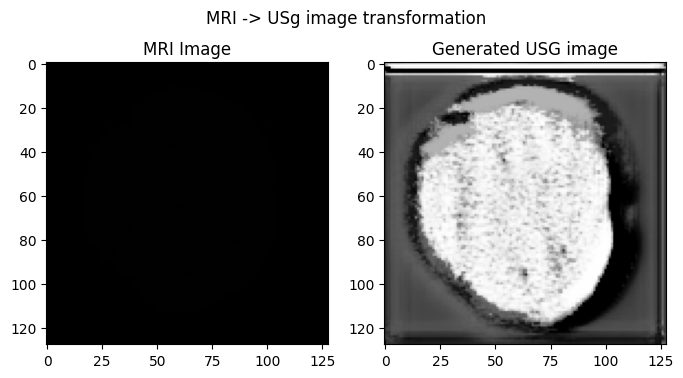

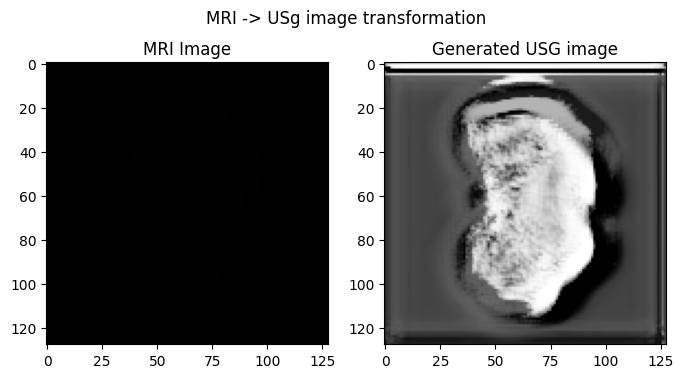

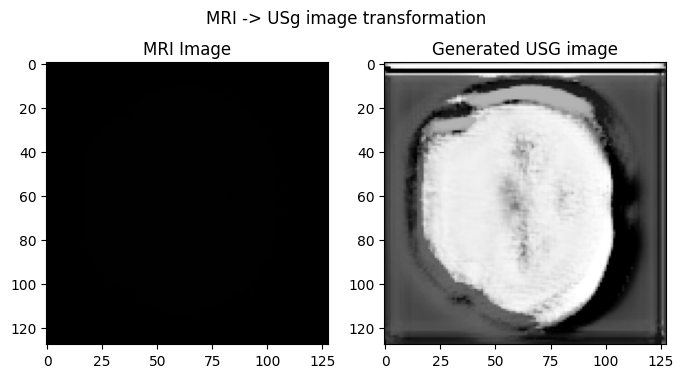

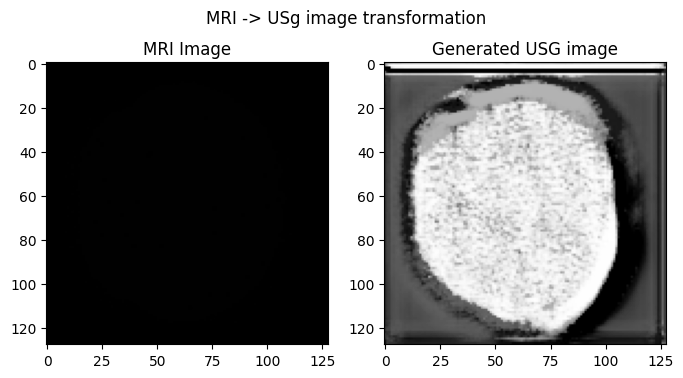

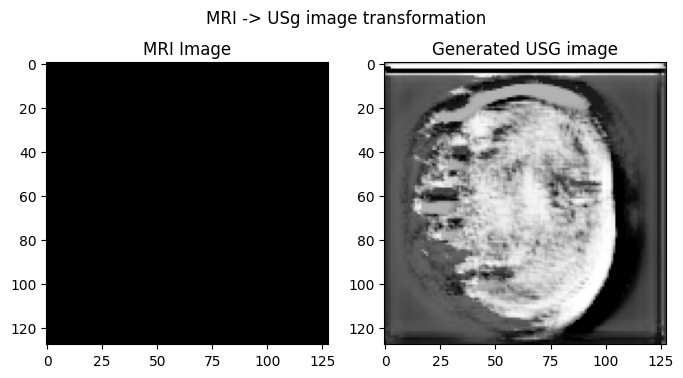

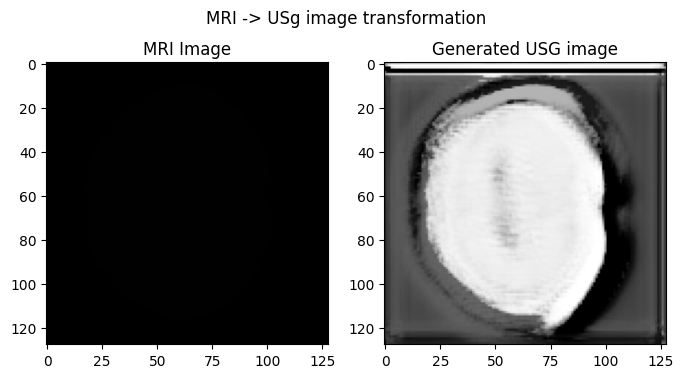

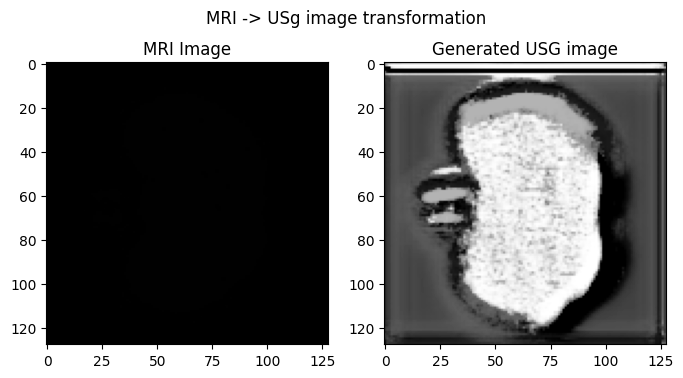

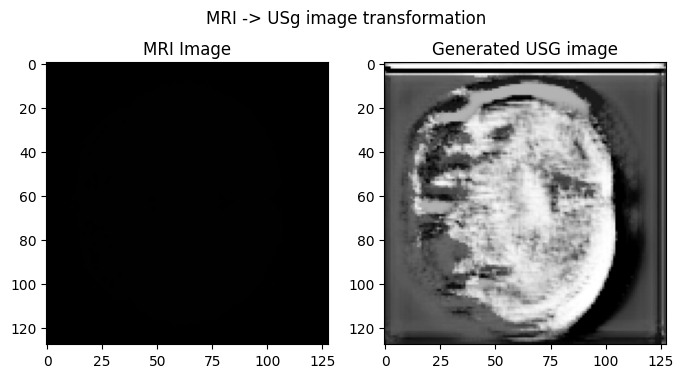

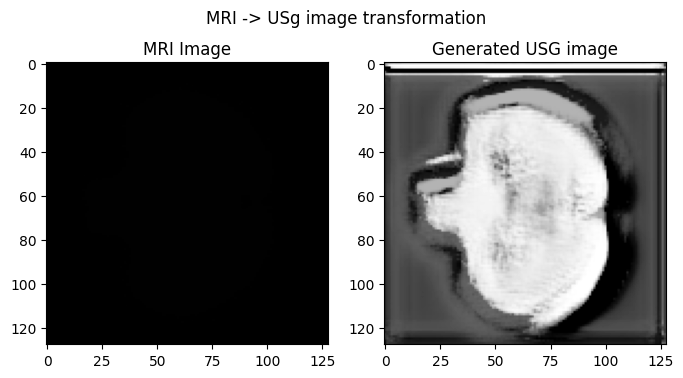

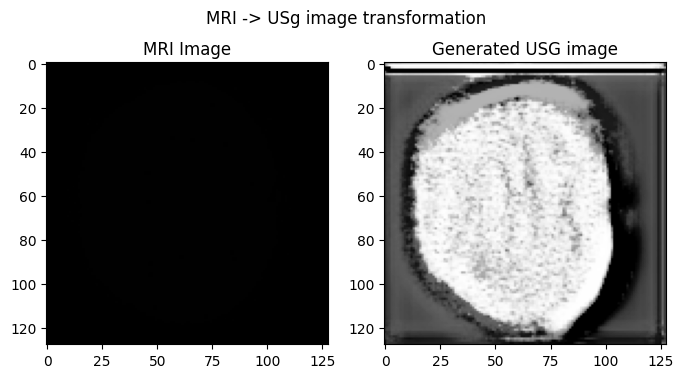

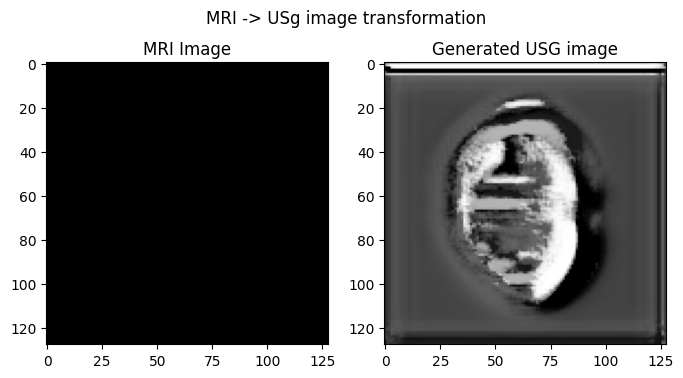

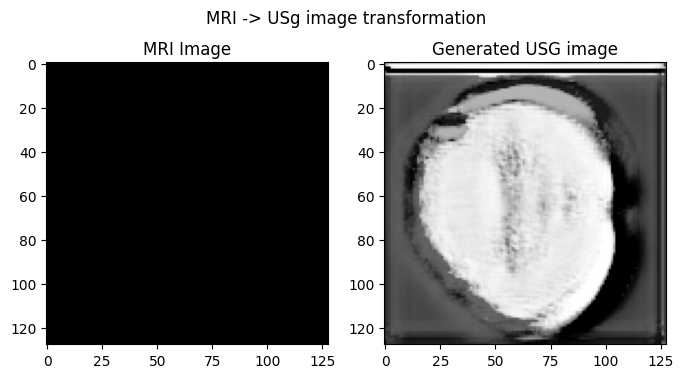

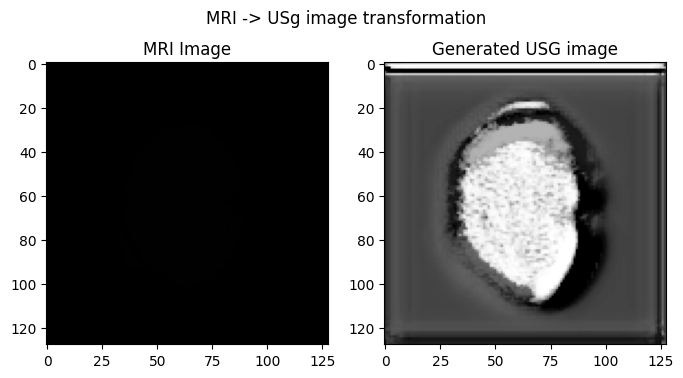

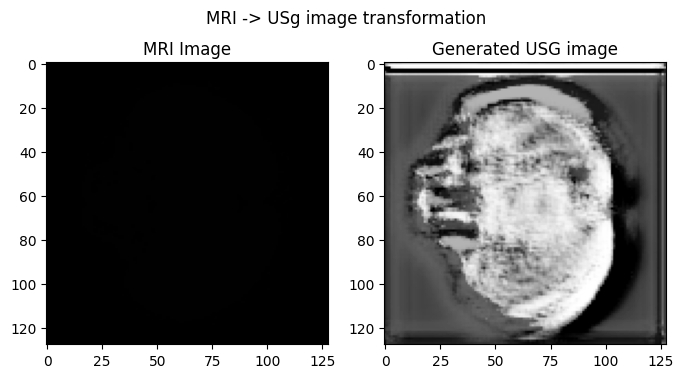

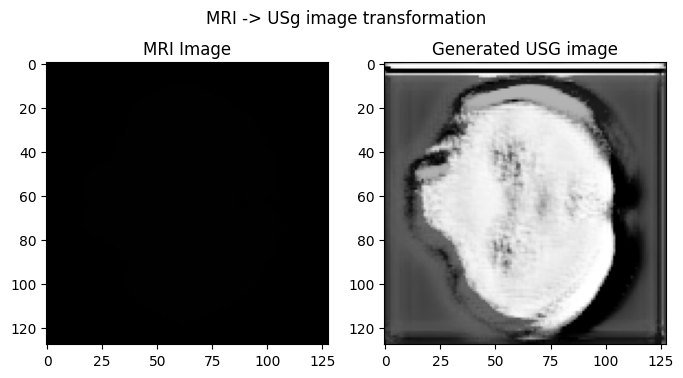

In [16]:
for i in range(0,len(mri_images)):
    plot_generator_image(mri_images[i]) 

